In [1]:
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 


In [3]:
def gather_data(path):
    full_df = pd.DataFrame()

    for folder in os.listdir(path):
        for filename in os.listdir(f'{path}/{folder}'):
            if filename.endswith(".csv"):
                df = pd.read_csv(f'{path}/{folder}/{filename}')
                # create date column
                df['date'] = filename.split('.')[0]
                df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
                full_df = pd.concat([full_df, df])
    return full_df

In [71]:
df = gather_data('../data/2023_articles_en')


In [210]:
len(df['label'].unique())

581

In [5]:
len(df.high_label.unique())

17

In [6]:
len(df.mid_label.unique())

295

In [7]:
df.columns

Index(['byline', 'channels', 'desk', 'headline', 'keywords', 'categories',
       'lede', 'places', 'priority', 'id', 'versioncreated', 'text', 'photos',
       'next', 'related', 'previous', 'specialCoverage', 'bert_embedding',
       'label', 'high_label', 'mid_label', 'ada_embedding', 'date',
       'correction', 'editorialRemarks', 'videoAlbums'],
      dtype='object')

# Data histograms

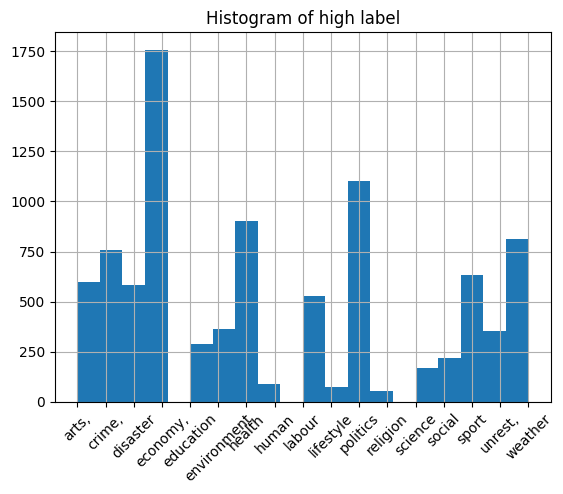

In [8]:
df.sort_values('high_label').high_label.str.split(' ').str[0].str[:11].hist(bins=20)
plt.title('Histogram of high label')
plt.xticks(rotation=45)
plt.show()

Text(0, 0.5, 'Count')

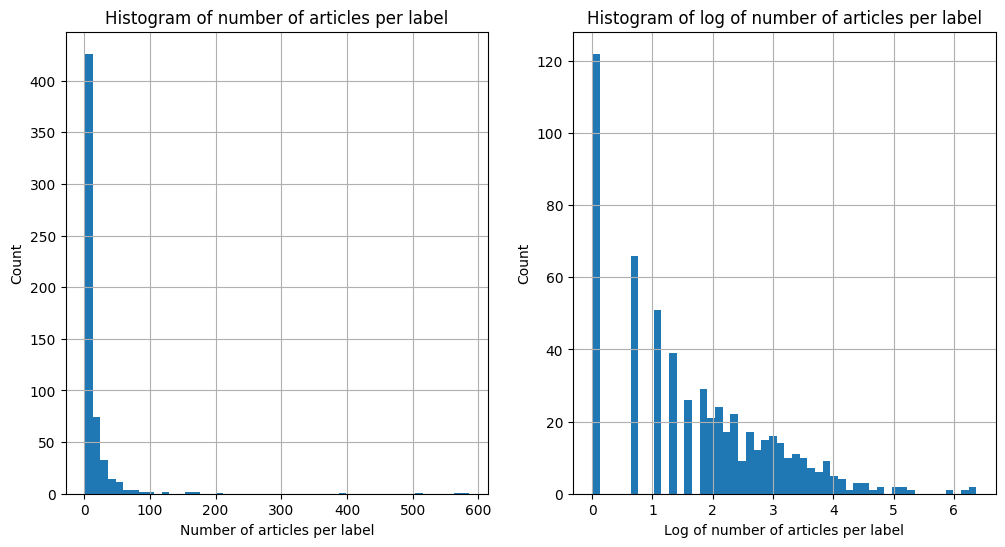

In [243]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)

d = df.groupby(df.label).count().byline
d.hist(bins=50)
plt.title('Histogram of number of articles per label')
plt.xlabel('Number of articles per label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)

d = df.groupby(df.label).count().byline
d = np.log(d)
d.hist(bins=50)
plt.title('Histogram of log of number of articles per label')
plt.xlabel('Log of number of articles per label')
plt.ylabel('Count')


In [251]:
df.groupby(df.label).count().byline.sort_values(ascending=False).head(5)

label
weather               586
european elections    574
poll                  507
parliament            390
stock splits          209
Name: byline, dtype: int64

In [246]:
d

label
African Games                 1
Australian rules football     1
C.E.O. interview              2
Grand Prix                   33
IT/computer sciences          2
                             ..
windstorms                   44
windsurfing                   7
work relations               17
world championship            5
zoology                       1
Name: byline, Length: 581, dtype: int64

# Word clouds

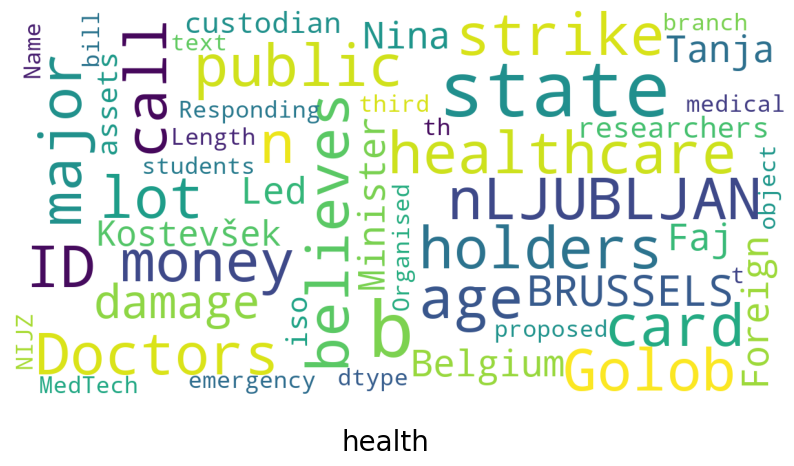

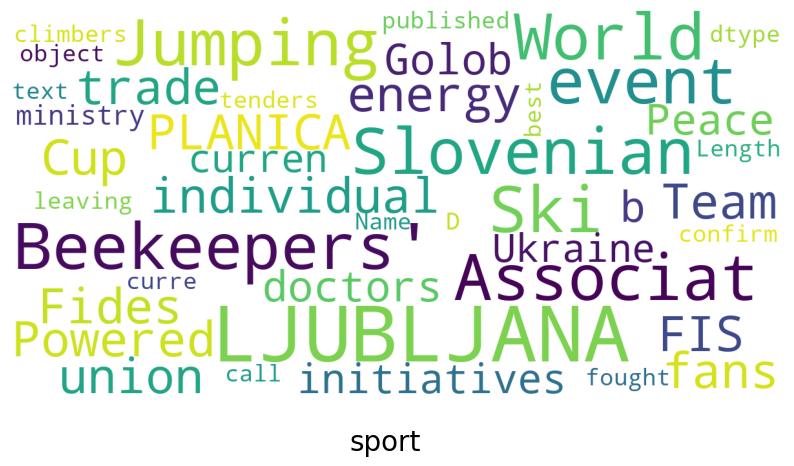

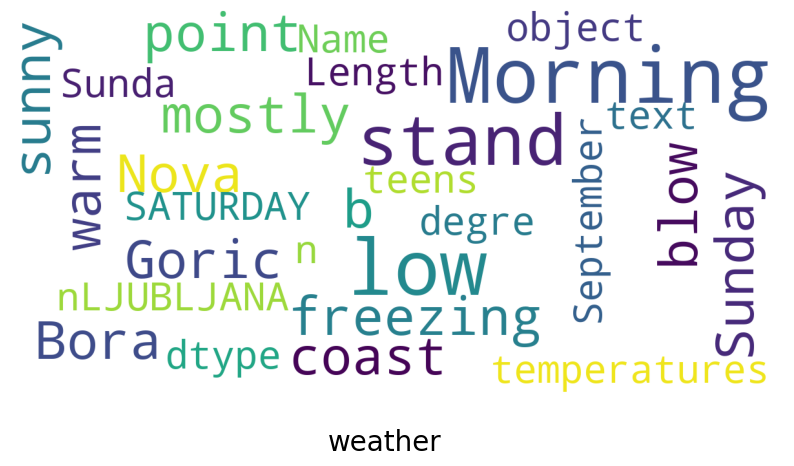

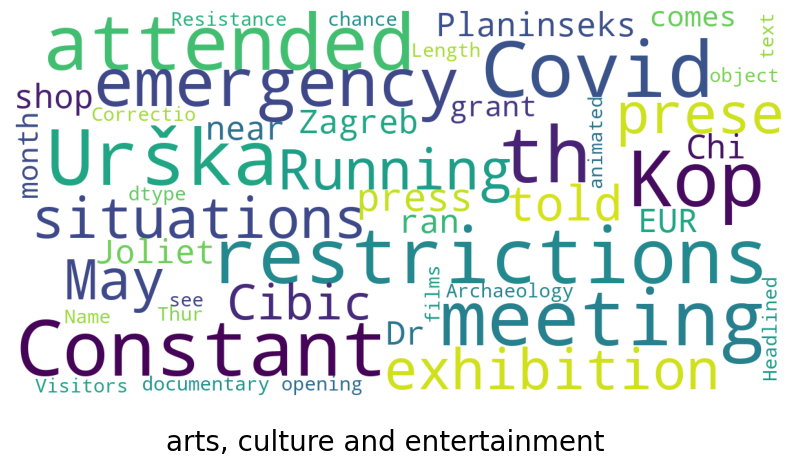

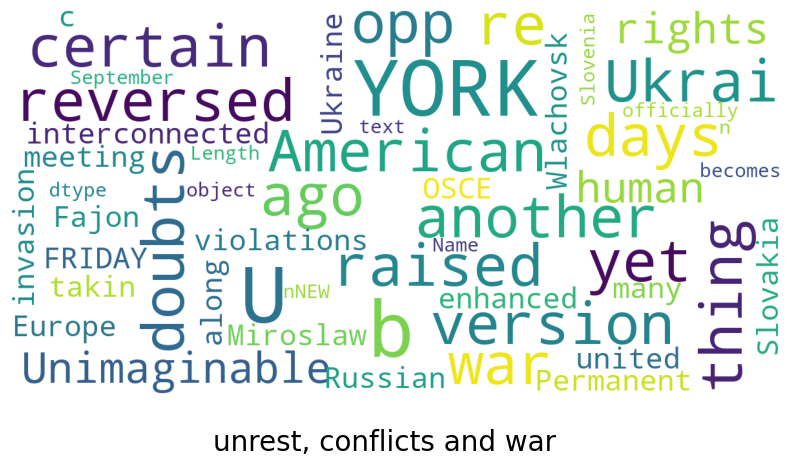

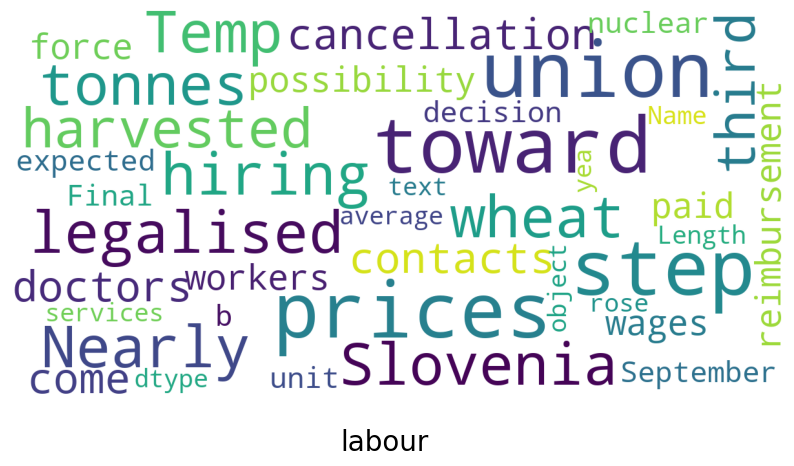

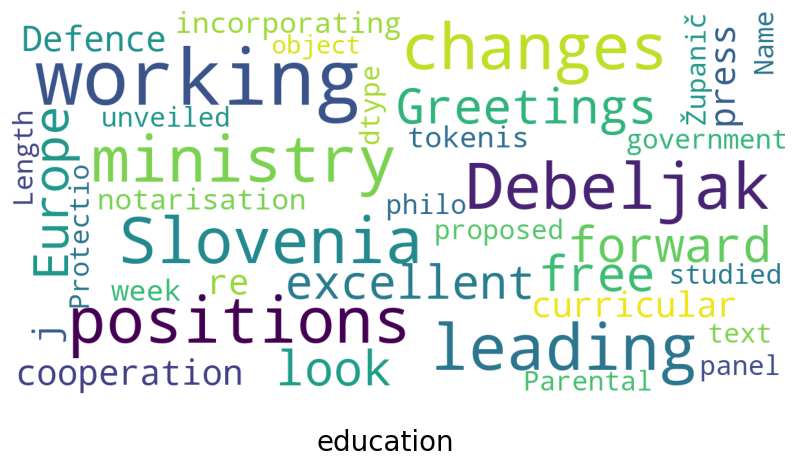

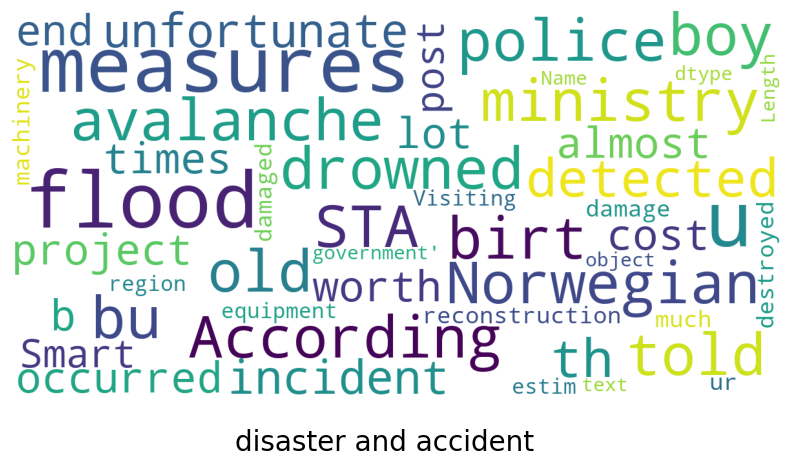

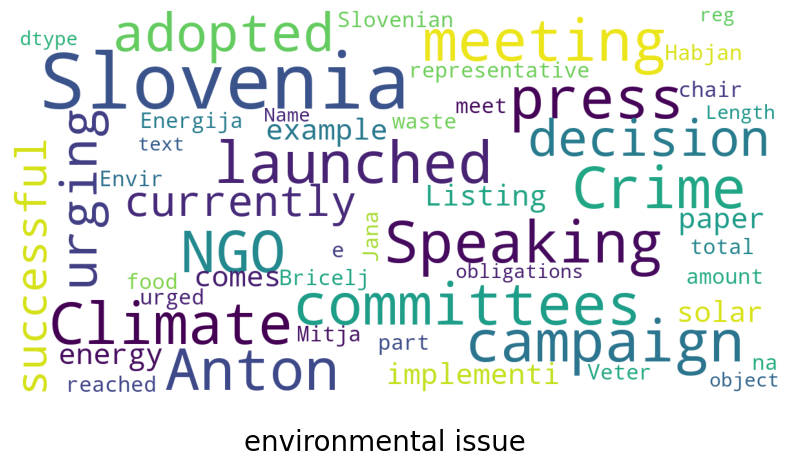

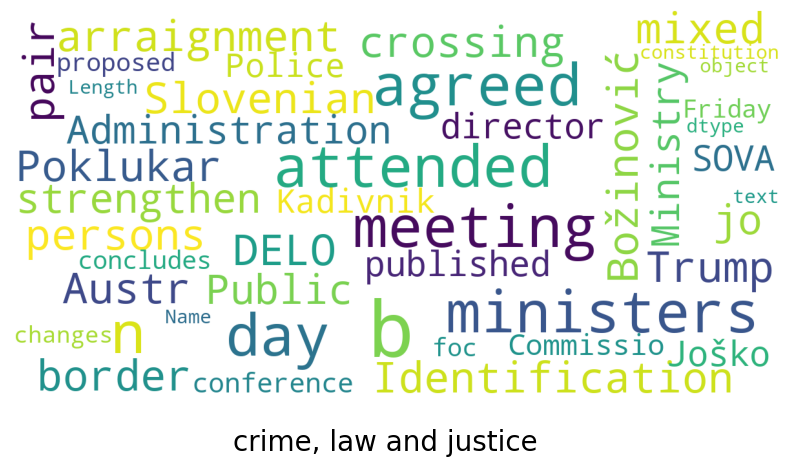

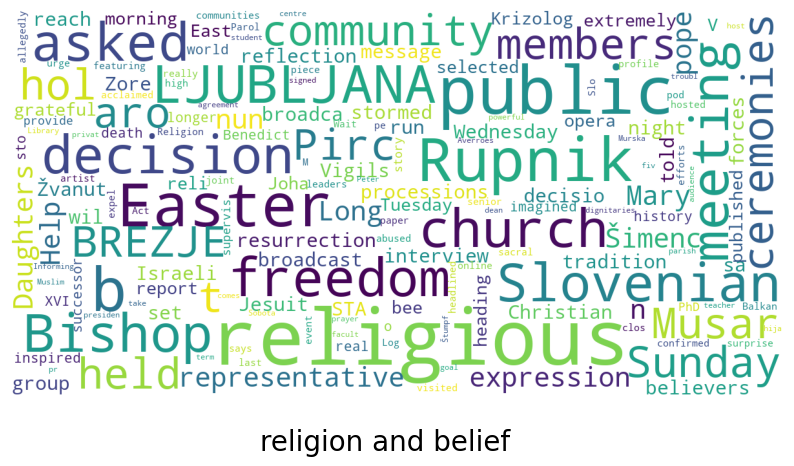

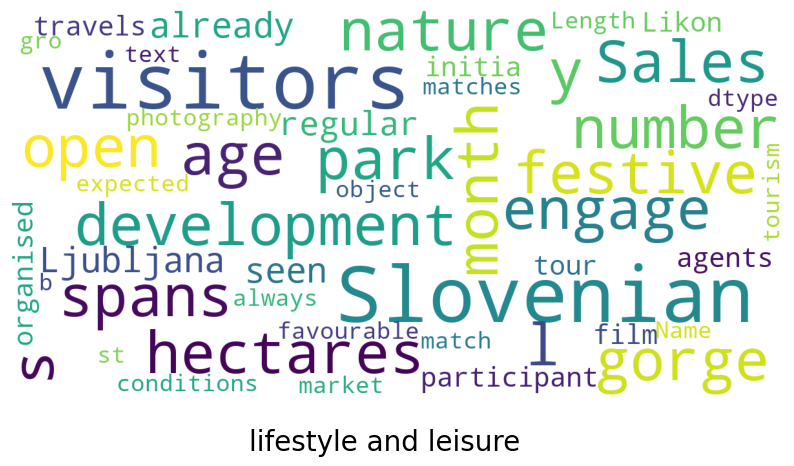

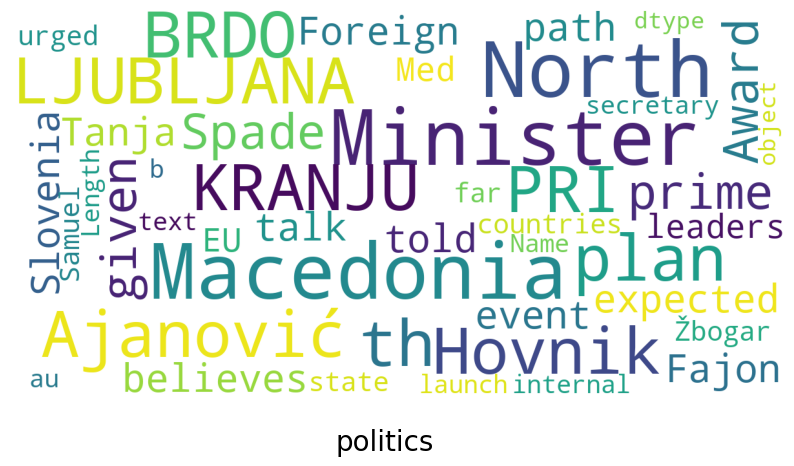

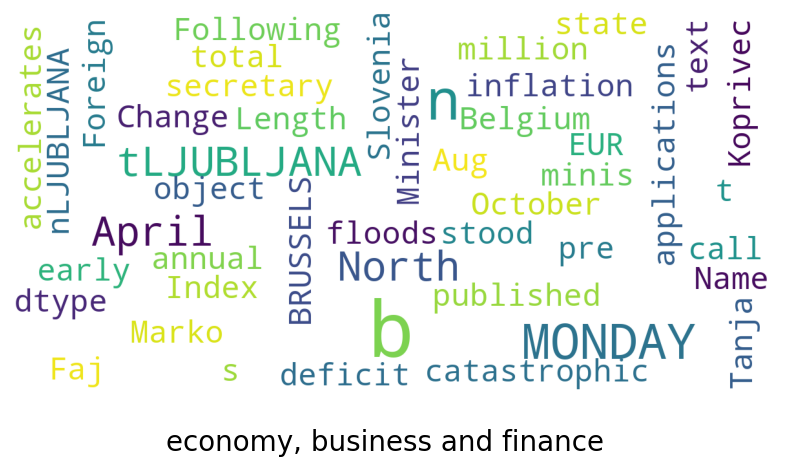

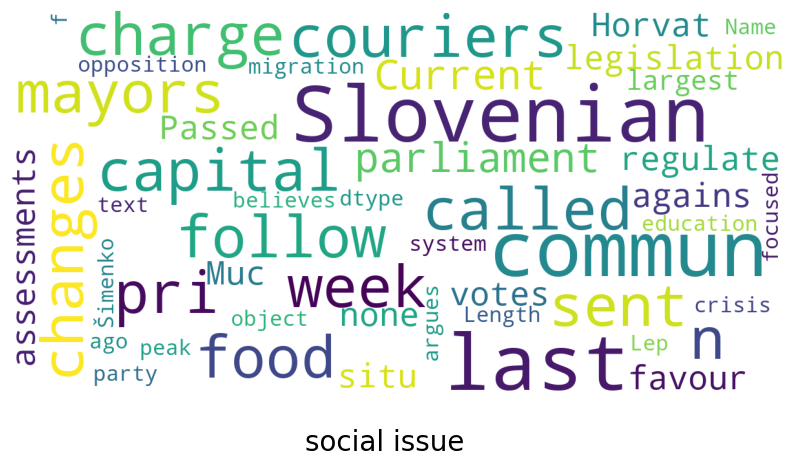

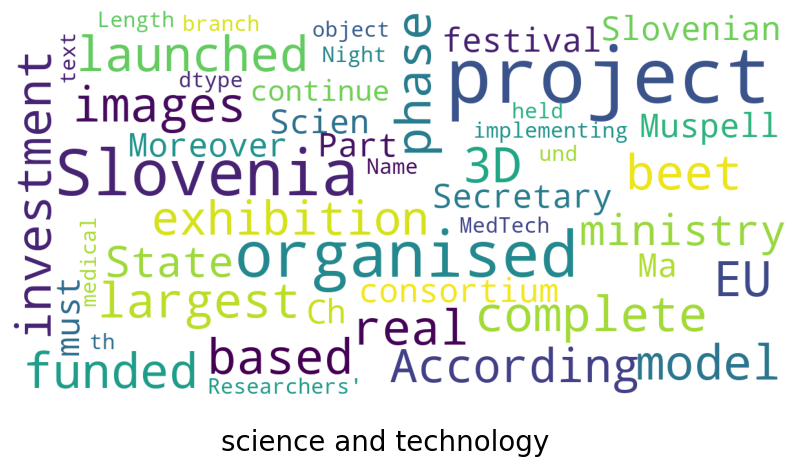

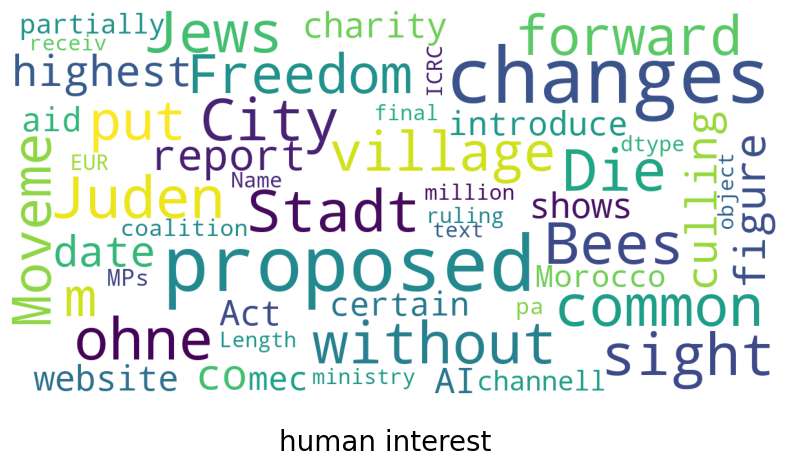

In [147]:
# show wordcloud for each high label
from wordcloud import WordCloud, STOPWORDS

def show_wordcloud(data, title = None):
    stopwords = set(STOPWORDS)
    stopwords.update(['said', 'say', 'will', 'one', 'now', 'new', 'year', 'years', 'time', 'also', 'first', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

for label in df.high_label.unique():
    show_wordcloud(df[df.high_label == label].text.dropna(), title=label)


# Number of common words between two labels

In [165]:
classes_text_words_dict = {}
for label in df.high_label.unique():
    classes_text_words_dict[label] = df[df.high_label == label].text.dropna().str.split(' ').sum()
    classes_text_words_dict[label] = set(classes_text_words_dict[label])
import networkx as nx
from itertools import combinations
from collections import Counter

G = nx.Graph()
for label in df.high_label.unique():
    G.add_node(label)
    for other_label in df.high_label.unique():
        if (label != other_label) & (G.has_edge(label, other_label) == False):
            G.add_edge(label, other_label, weight=len(classes_text_words_dict[label].intersection(classes_text_words_dict[other_label])))

In [166]:
# highest weighted edges
sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

[('politics', 'economy, business and finance', {'weight': 16716}),
 ('crime, law and justice',
  'economy, business and finance',
  {'weight': 14536}),
 ('crime, law and justice', 'politics', {'weight': 13369}),
 ('labour', 'economy, business and finance', {'weight': 12519}),
 ('arts, culture and entertainment',
  'economy, business and finance',
  {'weight': 11814}),
 ('sport', 'economy, business and finance', {'weight': 11736}),
 ('disaster and accident', 'economy, business and finance', {'weight': 11716}),
 ('labour', 'politics', {'weight': 11086}),
 ('health', 'economy, business and finance', {'weight': 10913}),
 ('unrest, conflicts and war',
  'economy, business and finance',
  {'weight': 10647}),
 ('unrest, conflicts and war', 'politics', {'weight': 10437}),
 ('sport', 'politics', {'weight': 10360}),
 ('arts, culture and entertainment', 'politics', {'weight': 10338}),
 ('disaster and accident', 'politics', {'weight': 10201}),
 ('labour', 'crime, law and justice', {'weight': 10120

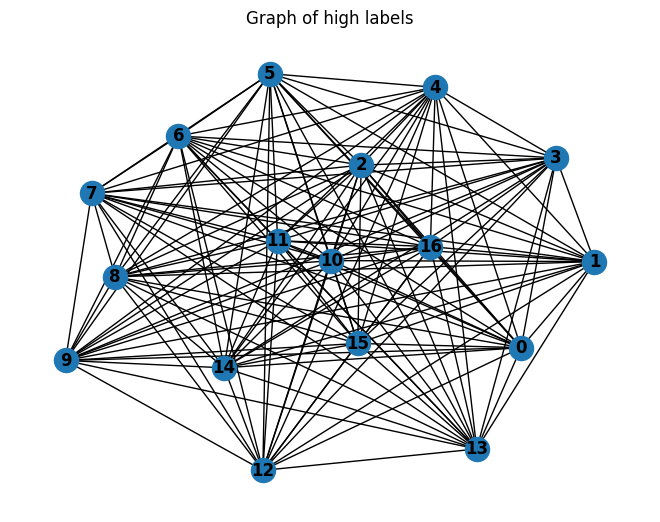

In [168]:
pos = nx.layout.kamada_kawai_layout(G)
# spring layout means that nodes with high
mapping = {}
for i, label in enumerate(df.high_label.unique()):
    mapping[label] = i
G = nx.relabel_nodes(G, mapping)

nx.draw(G, with_labels=True, font_weight='bold', pos=pos)
plt.title('Graph of high labels')
plt.show()


In [ ]:
# kamada_kawai_layout - minimizes energy of the graph
# that means that nodes with high edge weights are closer together
# and are highly correlated with all other nodes are in the center

In [143]:
for k in mapping.keys():
    print(k, mapping[k])

health 0
sport 1
weather 2
arts, culture and entertainment 3
unrest, conflicts and war 4
labour 5
education 6
disaster and accident 7
environmental issue 8
crime, law and justice 9
religion and belief 10
lifestyle and leisure 11
politics 12
economy, business and finance 13
social issue 14
science and technology 15
human interest 16


In [157]:
classes_text_words_dict = {}
for label in df.mid_label.unique():
    classes_text_words_dict[label] = df[df.mid_label == label].text.dropna().str.split(' ').sum()
    classes_text_words_dict[label] = set(classes_text_words_dict[label])

In [158]:
import networkx as nx
from itertools import combinations
from collections import Counter

G = nx.Graph()
for label in df.mid_label.unique():
    G.add_node(label)
    for other_label in df.mid_label.unique():
        if (label != other_label) & (G.has_edge(label, other_label) == False):
            G.add_edge(label, other_label, weight=len(classes_text_words_dict[label].intersection(classes_text_words_dict[other_label])))

In [159]:
# highest weighted edges
sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

[('parliament', 'foreign aid', {'weight': 9934}),
 ('parliament', 'referenda', {'weight': 9493}),
 ('ski jumping', 'parliament', {'weight': 8523}),
 ('diplomacy', 'parliament', {'weight': 8070}),
 ('foreign aid', 'referenda', {'weight': 7529}),
 ('diplomacy', 'foreign aid', {'weight': 7053}),
 ('parliament', 'flood', {'weight': 6910}),
 ('ski jumping', 'foreign aid', {'weight': 6877}),
 ('ski jumping', 'referenda', {'weight': 6624}),
 ('foreign aid', 'flood', {'weight': 6263}),
 ('diplomacy', 'referenda', {'weight': 6250}),
 ('parliament', 'tourism', {'weight': 6060}),
 ('ski jumping', 'diplomacy', {'weight': 5642}),
 ('referenda', 'flood', {'weight': 5585}),
 ('ski jumping', 'flood', {'weight': 5475}),
 ('foreign aid', 'tourism', {'weight': 5354}),
 ('parliament', 'crime', {'weight': 5163}),
 ('parliament', 'private health care', {'weight': 4927}),
 ('referenda', 'tourism', {'weight': 4905}),
 ('diplomacy', 'flood', {'weight': 4863}),
 ('ski jumping', 'tourism', {'weight': 4792}),
 ('

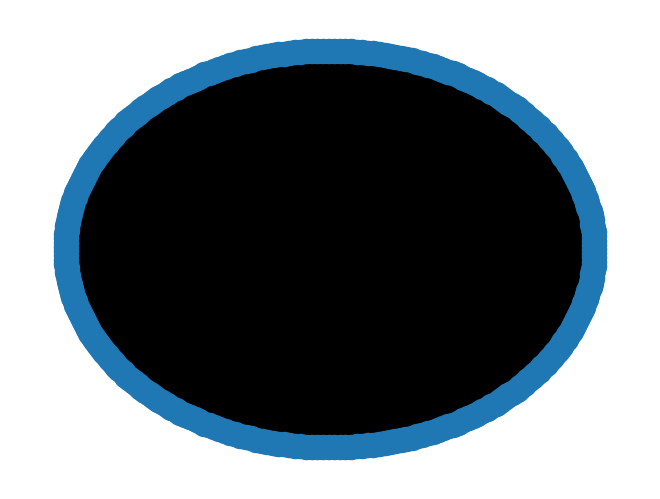

In [162]:
pos = nx.layout.circular_layout(G)
# replace labels with numbers
mapping = {}
for i, label in enumerate(df.mid_label.unique()):
    mapping[label] = i
G = nx.relabel_nodes(G, mapping)

nx.draw(G, with_labels=False, font_weight='bold', pos=pos)
plt.show()



In [163]:
for k in mapping.keys():
    print(k, mapping[k])

people 0
ski jumping 1
weather science 2
sailing 3
civil unrest 4
labour legislation 5
diplomacy 6
armed conflict 7
missing person 8
global warming 9
police 10
nordic skiing 11
religious festival or holiday 12
agriculture 13
physical fitness 14
labour dispute 15
award and prize 16
parliament 17
windsurfing 18
social issues (general) 19
health insurance 20
duathlon 21
foreign aid 22
private health care 23
hornuss 24
religious event 25
referenda 26
travel and commuting 27
aero and aviation sport 28
forecast 29
election 30
employer 31
internet 32
minority group 33
further education 34
space programme 35
tourism 36
macro economics 37
crisis 38
painting 39
unions 40
company information 41
identification technology 42
darts 43
freedom of the press 44
work relations 45
advanced training 46
health organisations 47
relief and aid organisation 48
international organisation 49
cinema 50
euthanasia (also includes assisted suicide) 51
charity 52
migration 53
crime 54
motorcycling 55
unemployment 56

# The most common word between two classes

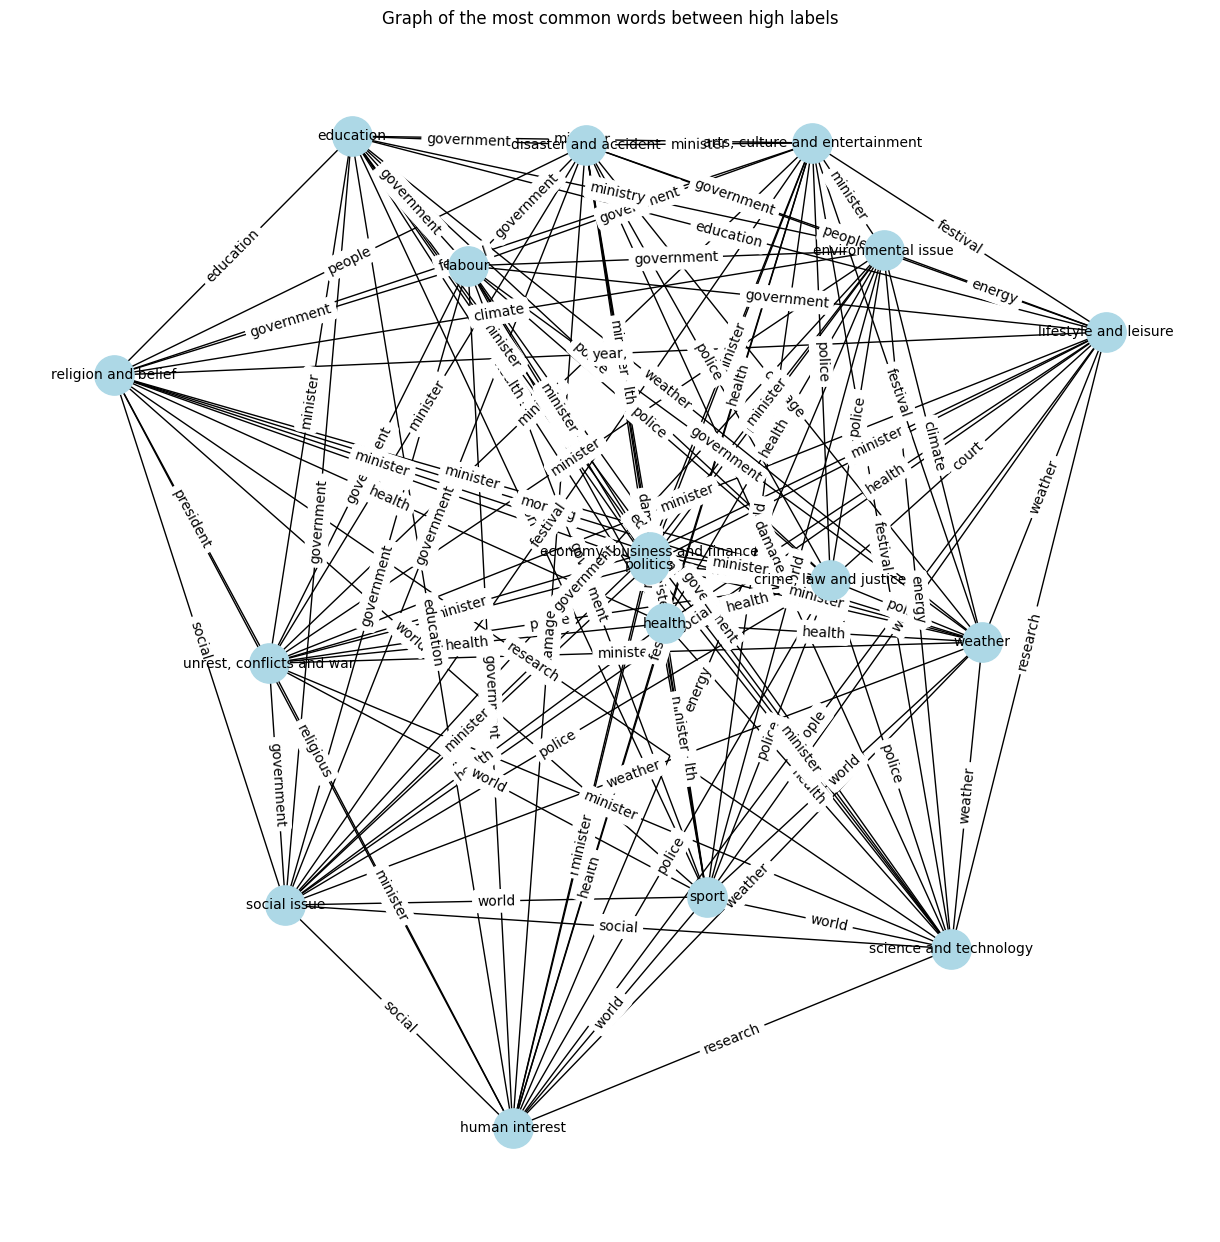

In [261]:
import networkx as nx
from collections import Counter


classes_text_words_dict = {}
for label in df.high_label.unique():
    words = df[df.high_label == label].text.dropna().str.split()
    # drop word 'the', 'a', 'an'
    words = words.apply(lambda x: [word.lower() for word in x if (word.lower() not in ['the', 'a', 'an', 'of', 'slovenian','ljubljana', 'first'] + list(STOPWORDS)) & (len(word) > 4) & ('ovenia' not in word) & ('ljub' not in word) & ('said' not in word)])
    words = words.sum()
    classes_text_words_dict[label] = Counter(words)

G = nx.Graph()

for label in df.high_label.unique():
    G.add_node(label)

for label1, label2 in combinations(df.high_label.unique(), 2):
    words1 = classes_text_words_dict[label1]
    words2 = classes_text_words_dict[label2]
    
    common_words = list((words1 & words2).elements()) 
    if common_words:
        most_common_word = max(common_words, key=lambda word: (words1[word] + words2[word]))
        weight = words1[most_common_word] + words2[most_common_word]
        G.add_edge(label1, label2, common_word=most_common_word, weight=weight)

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'common_word')
nx.draw(G, pos, with_labels=True, node_size=800, node_color='lightblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title('Graph of the most common words between high labels')
plt.show()


In [170]:
# list of words in each edge
word2edge = {}
for edge in G.edges(data=True):
    word2edge[edge[0] + ' ' + edge[1]] = edge[2]['common_word']
    

In [171]:
word2edge

{'health sport': 'health',
 'health weather': 'health',
 'health arts, culture and entertainment': 'health',
 'health unrest, conflicts and war': 'health',
 'health labour': 'health',
 'health education': 'health',
 'health disaster and accident': 'health',
 'health environmental issue': 'health',
 'health crime, law and justice': 'health',
 'health religion and belief': 'health',
 'health lifestyle and leisure': 'health',
 'health politics': 'minister',
 'health economy, business and finance': 'minister',
 'health social issue': 'health',
 'health science and technology': 'health',
 'health human interest': 'health',
 'sport weather': 'world',
 'sport arts, culture and entertainment': 'world',
 'sport unrest, conflicts and war': 'world',
 'sport labour': 'government',
 'sport education': 'world',
 'sport disaster and accident': 'damage',
 'sport environmental issue': 'world',
 'sport crime, law and justice': 'police',
 'sport religion and belief': 'world',
 'sport lifestyle and leisur

In [172]:
import networkx as nx
from collections import Counter


classes_text_words_dict = {}
for label in df.mid_label.unique():
    words = df[df.mid_label == label].text.dropna().str.split()
    # drop word 'the', 'a', 'an'
    words = words.apply(lambda x: [word.lower() for word in x if (word.lower() not in ['the', 'a', 'an', 'of', 'slovenian','ljubljana', 'first'] + list(STOPWORDS)) & (len(word) > 4) & ('ovenia' not in word) & ('ljub' not in word) & ('said' not in word)])
    words = words.sum()
    classes_text_words_dict[label] = Counter(words)

G = nx.Graph()

for label in df.mid_label.unique():
    G.add_node(label)

for label1, label2 in combinations(df.mid_label.unique(), 2):
    words1 = classes_text_words_dict[label1]
    words2 = classes_text_words_dict[label2]
    
    common_words = list((words1 & words2).elements()) 
    if common_words:
        most_common_word = max(common_words, key=lambda word: (words1[word] + words2[word]))
        weight = words1[most_common_word] + words2[most_common_word]
        G.add_edge(label1, label2, common_word=most_common_word, weight=weight)

# list of words in each edge
word2edge = {}
for edge in G.edges(data=True):
    word2edge[edge[0] + ', ' + edge[1]] = edge[2]['common_word']
    
word2edge

In [213]:
words

0

In [214]:
label

'luge'

In [218]:
df[df.label == 'luge'].text.dropna().str.split().sum()

0

In [224]:
type(words)

int

In [262]:
import networkx as nx
from collections import Counter


classes_text_words_dict = {}
for label in df.label.unique():
    words = df[df.label == label].text.dropna().str.split()
    if type(words) == int:
        classes_text_words_dict[label] = Counter()
        continue
    # drop word 'the', 'a', 'an'
    words = words.apply(lambda x: [word.lower() for word in x if (word.lower() not in ['the', 'a', 'an', 'of', 'slovenian','ljubljana', 'first'] + list(STOPWORDS)) & (len(word) > 4) & ('ovenia' not in word) & ('ljub' not in word) & ('said' not in word)])
    words = words.sum()
    if type(words) == int:
        classes_text_words_dict[label] = Counter()
        continue
    classes_text_words_dict[label] = Counter(words)

G = nx.Graph()

for label in df.label.unique():
    G.add_node(label)

for label1, label2 in combinations(df.label.unique(), 2):
    words1 = classes_text_words_dict[label1]
    words2 = classes_text_words_dict[label2]
    
    common_words = list((words1 & words2).elements()) 
    if common_words:
        most_common_word = max(common_words, key=lambda word: (words1[word] + words2[word]))
        weight = words1[most_common_word] + words2[most_common_word]
        G.add_edge(label1, label2, common_word=most_common_word, weight=weight)

# list of words in each edge
word2edge = {}
for edge in G.edges(data=True):
    word2edge[edge[0] + ', ' + edge[1]] = edge[2]['common_word']
    
word2edge

{'poll, ski jumping': 'third',
 'poll, weather': 'around',
 'poll, sailing': 'three',
 'poll, revolutions': 'society',
 'poll, public employees': 'demands',
 'poll, diplomacy': 'former',
 'poll, international military intervention': 'support',
 'poll, european elections': 'support',
 'poll, maritime accident': 'people',
 'poll, global warming': 'respondents',
 'poll, police': 'three',
 'poll, avalanche/landslide': 'around',
 'poll, religious festival or holiday': 'people',
 'poll, arable farming': '2022,',
 'poll, physical fitness': 'respondents',
 'poll, health-workers union': 'support',
 'poll, award and prize': 'culture',
 'poll, parliament': 'organised',
 'poll, windstorms': 'around',
 'poll, heads of state': 'former',
 'poll, social services': 'people',
 'poll, health insurance': 'three',
 'poll, Grand Prix': 'three',
 'poll, private health care': 'people',
 'poll, hornuss': 'institute,',
 'poll, roman catholic': 'around',
 'poll, public finance': 'among',
 'poll, railway': 'three

In [298]:
n=5000
list(word2edge.keys())[n]

'european elections, crime, law and justice'

In [299]:
word2edge[list(word2edge.keys())[n]]

'minister'

In [ ]:
'european elections, crime, law and justice': 'minister',
'award and prize, prescription drugs': 'public',

In [ ]:
{'poll, ski jumping': 'third',
 'poll, weather': 'around',
 'poll, sailing': 'three',
 'poll, revolutions': 'society',
 'poll, public employees': 'demands',
 'poll, diplomacy': 'former',
 'poll, international military intervention': 'support',
 'poll, european elections': 'support',
 'poll, maritime accident': 'people',
 'poll, global warming': 'respondents',
 'poll, police': 'three',
 'poll, avalanche/landslide': 'around',
 'poll, religious festival or holiday': 'people',
 'poll, arable farming': '2022,',
 'poll, physical fitness': 'respondents',
 'poll, health-workers union': 'support',
 'poll, award and prize': 'culture',
 'poll, parliament': 'organised',
 'poll, windstorms': 'around',
 'poll, heads of state': 'former',
 'poll, social services': 'people',
 'poll, health insurance': 'three',
 'poll, Grand Prix': 'three',
 'poll, private health care': 'people',
 'poll, hornuss': 'institute,',
...
 'ski jumping, criminal': 'second',
 'ski jumping, metal': 'expected',
 'ski jumping, club and association': 'minister',
 'ski jumping, entrance examination': 'world',

# Distribution of message lengths in each high category

In [176]:
df = gather_data('../data/2023_articles_en')

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


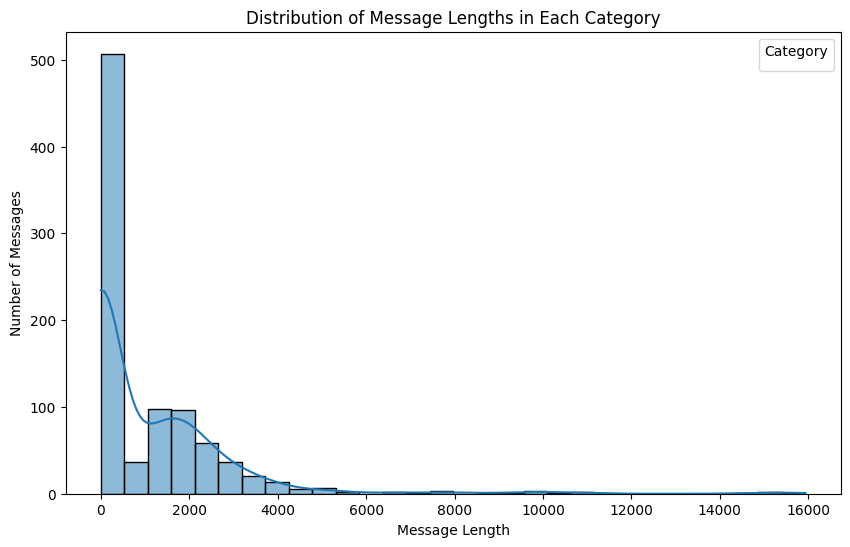

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


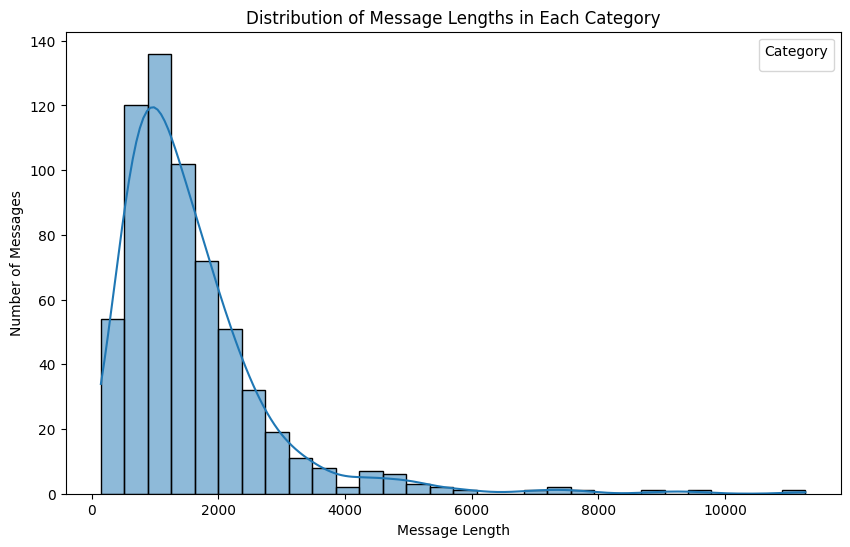

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


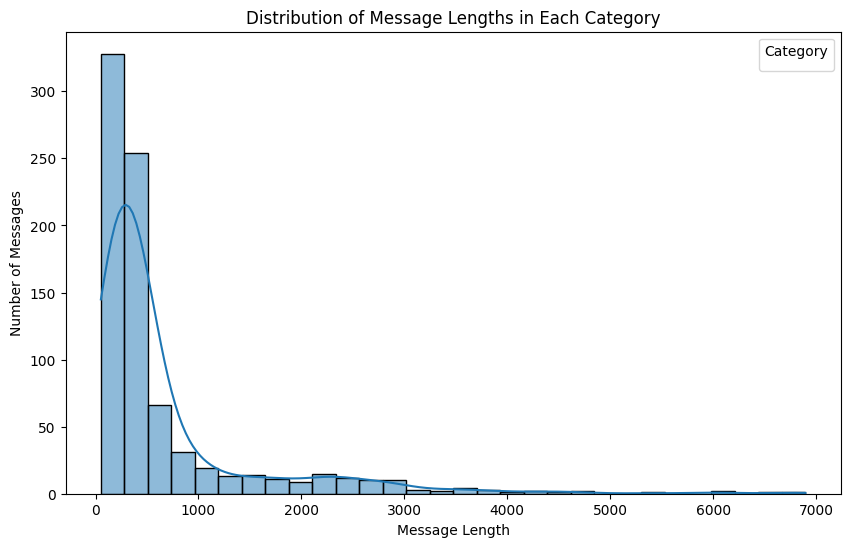

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


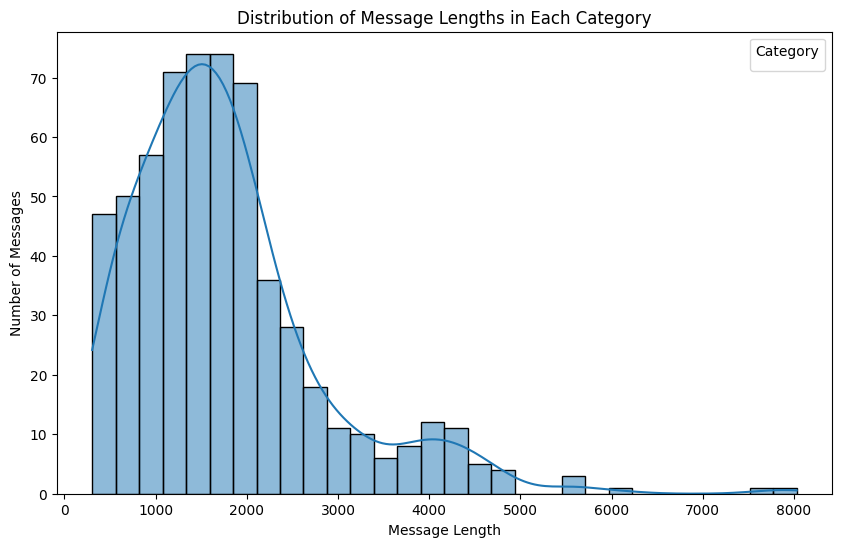

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


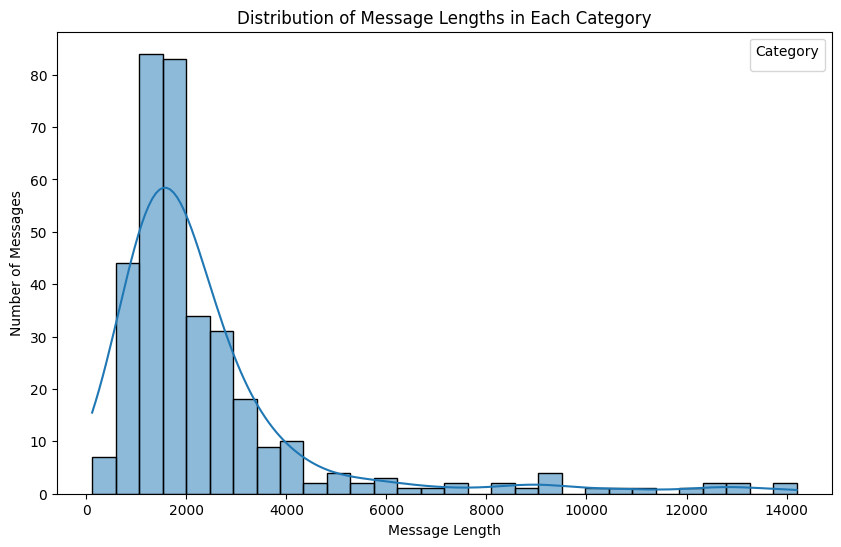

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


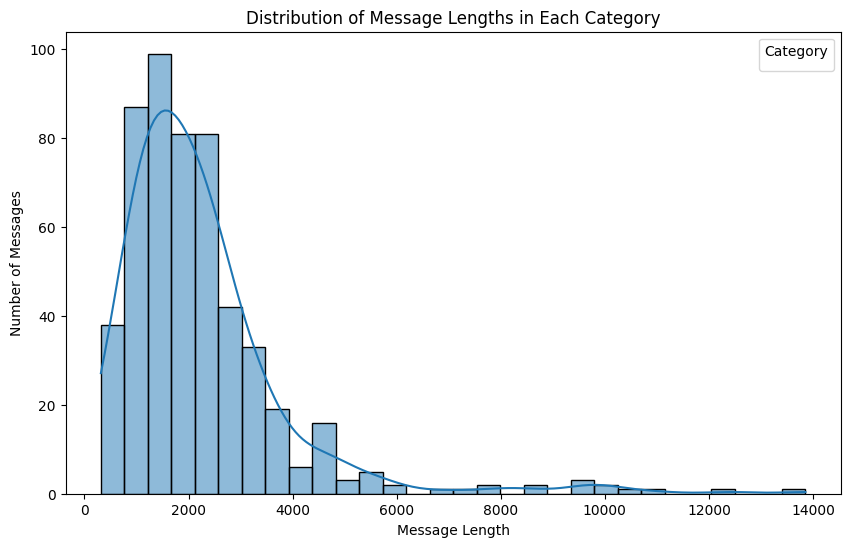

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


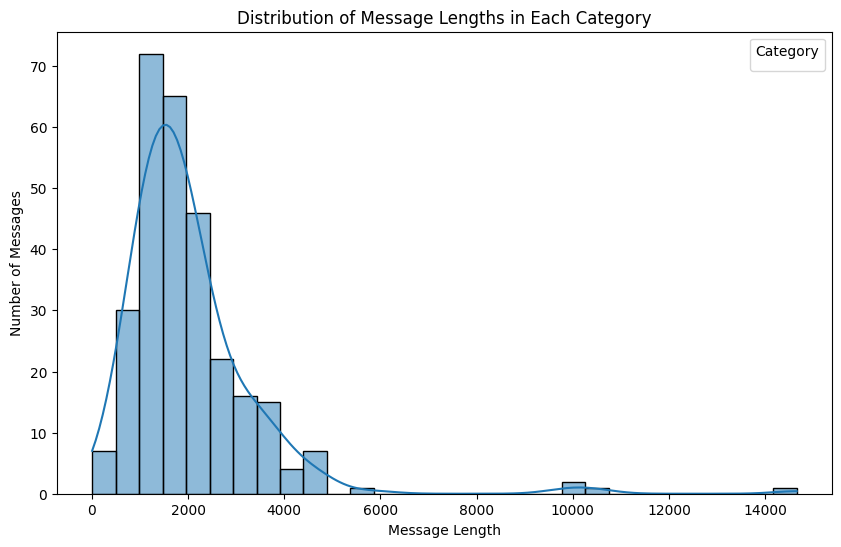

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


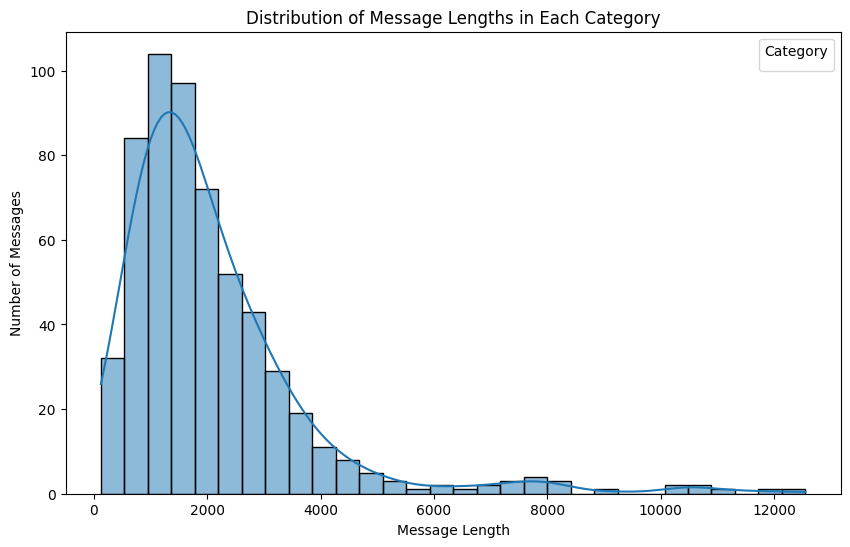

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


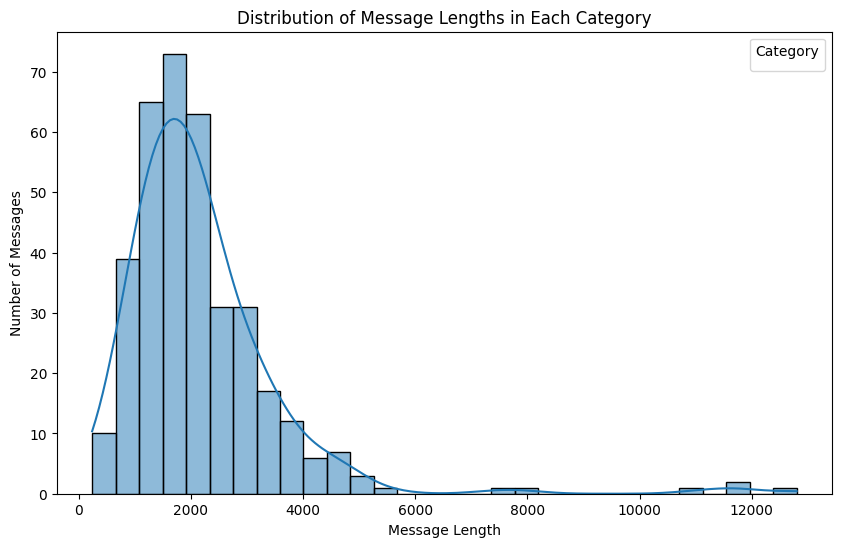

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


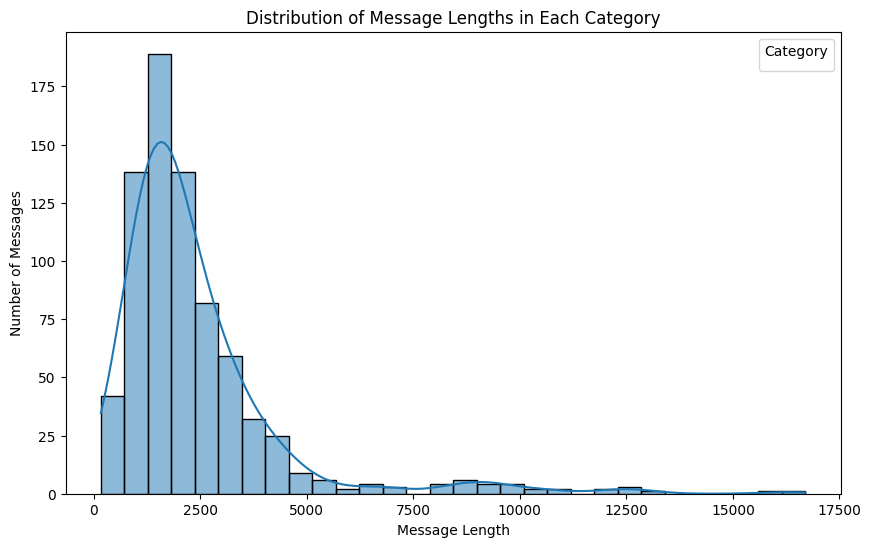

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


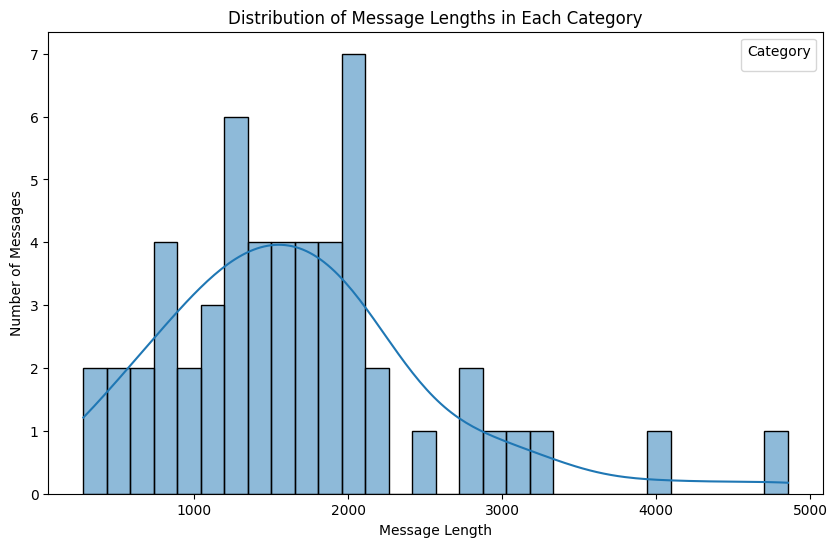

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


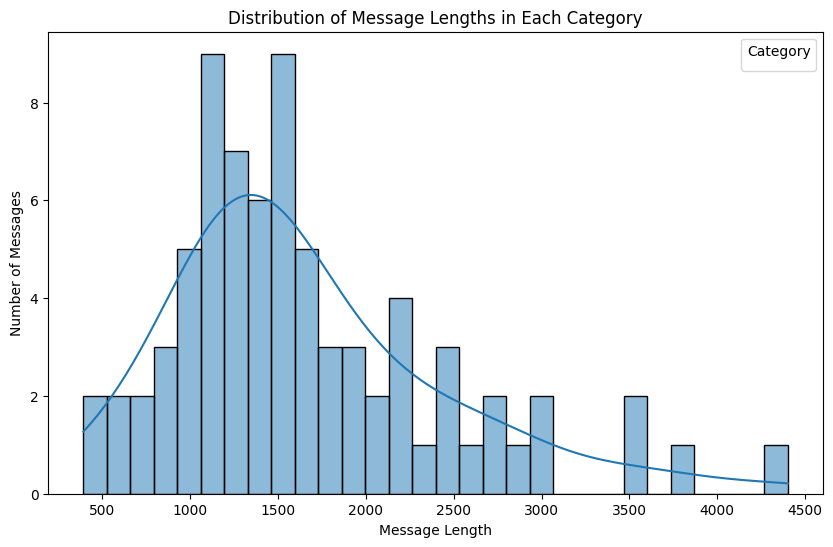

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


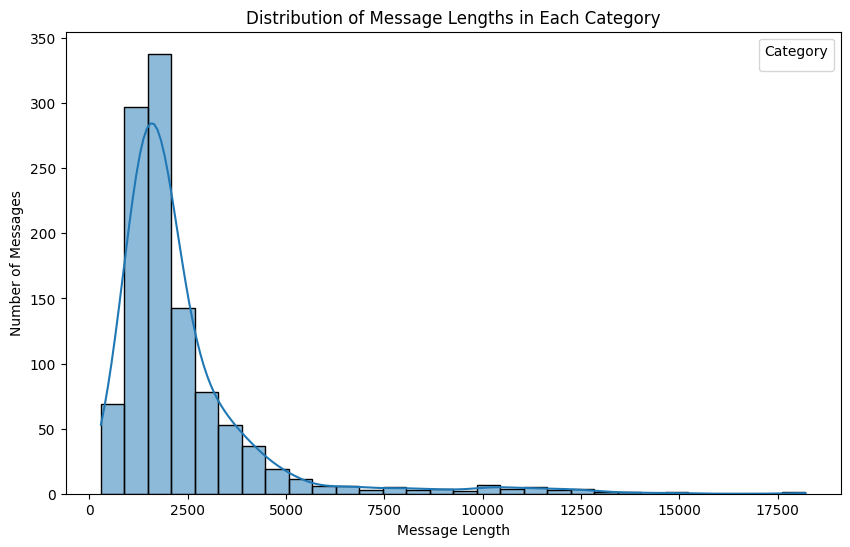

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


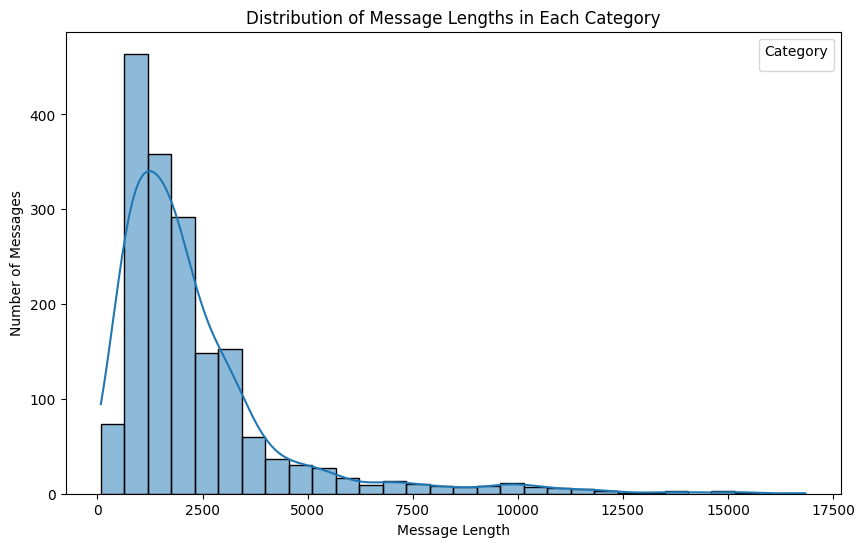

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


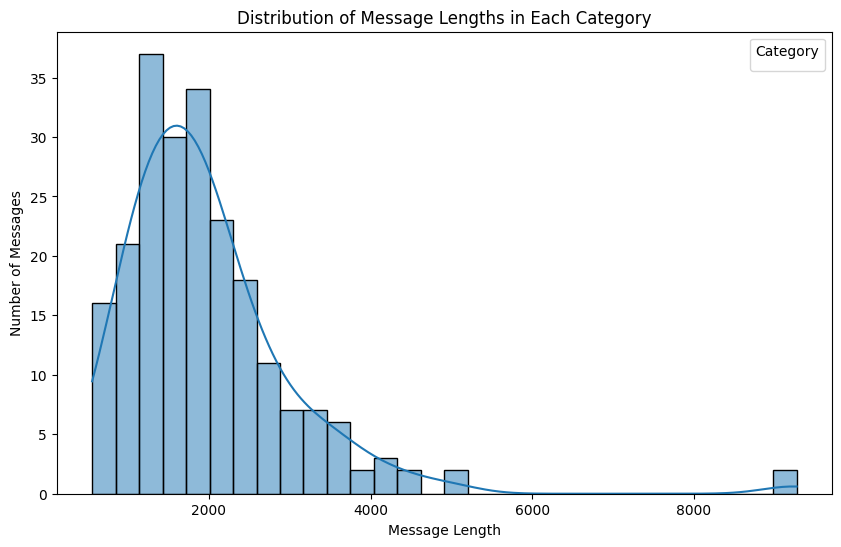

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


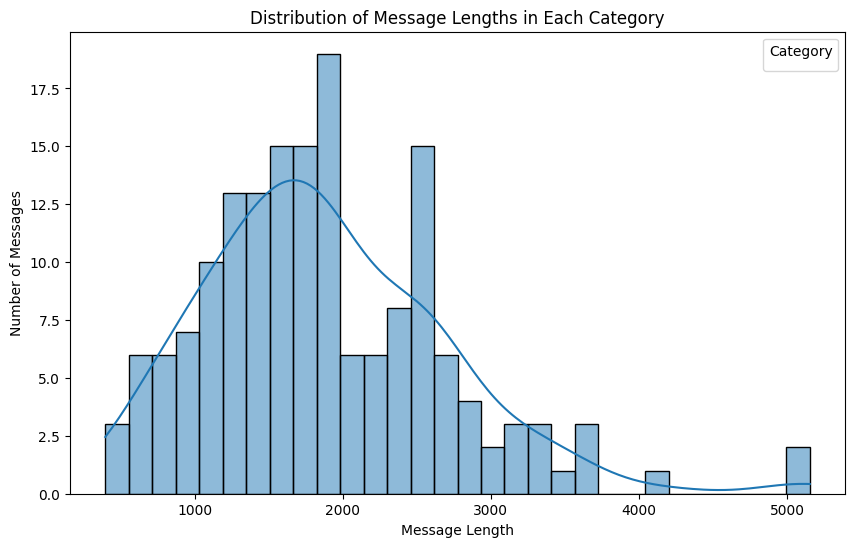

C:\Users\mikol\AppData\Local\Temp\ipykernel_11164\1109909059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d['message_length'] = d['text'].apply(lambda x :len(str(x)))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


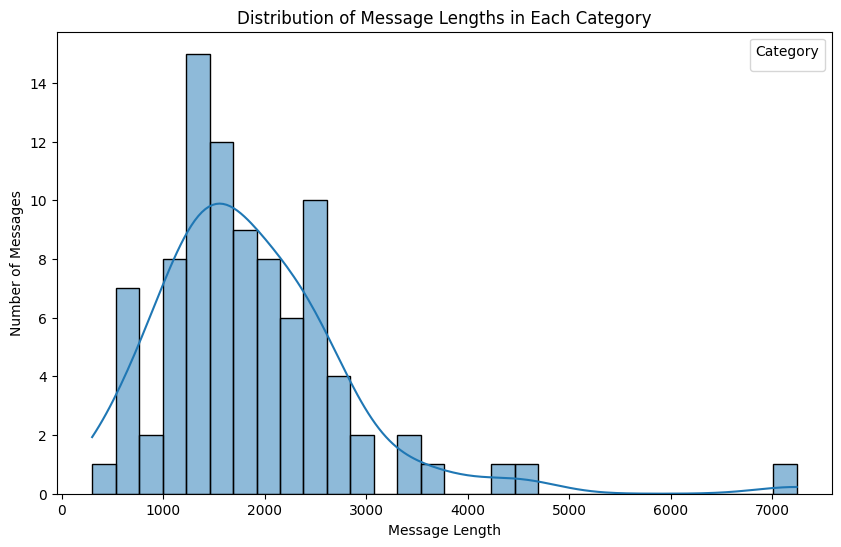

In [179]:
# Distribution of message lengths in each category
for label in df.high_label.unique():
    d = df[df.high_label == label]
    d['message_length'] = d['text'].apply(lambda x :len(str(x)))

    plt.figure(figsize=(10, 6))
    sns.histplot(data=d, x='message_length', hue='high_label', bins=30, kde=True)
    plt.xlabel('Message Length')
    plt.ylabel('Number of Messages')
    plt.title('Distribution of Message Lengths in Each Category')
    plt.legend(title='Category')
    plt.show()


# Most common words in each category

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

d = df[df.text.notna()]  # Filter out rows with empty text

# Create a function to extract keywords from text
def extract_keywords(text, num_keywords=10):
    words = text.split()
    word_counts = Counter(words)
    # remove stopwords from word_counts
    stopwords = set(STOPWORDS)
    stopwords.update(['said', 'say', 'will', 'one', 'now', 'new', 'year', 'years', 'time', 'also', 'first', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'the', '-', 'a', 'it', 'The'])
    for stopword in stopwords:
        if stopword.lower() in word_counts:
            del word_counts[stopword]
    to_del = []
    for word in word_counts:
        if len(word) < 4:
            to_del.append(word)
    for word in to_del:
        del word_counts[word]
    keywords = [(word, count) for word, count in word_counts.most_common(num_keywords)]
    return keywords

# Extract keywords and their counts for each category
category_keywords = {}
categories = d['high_label'].unique()

for category in categories:
    text = " ".join(d[d['high_label'] == category]['text'])
    keywords = extract_keywords(text)
    category_keywords[category] = keywords

# Plot bar charts for keywords in each category with counts
num_keywords_to_plot = 10  # Number of keywords to plot for each category


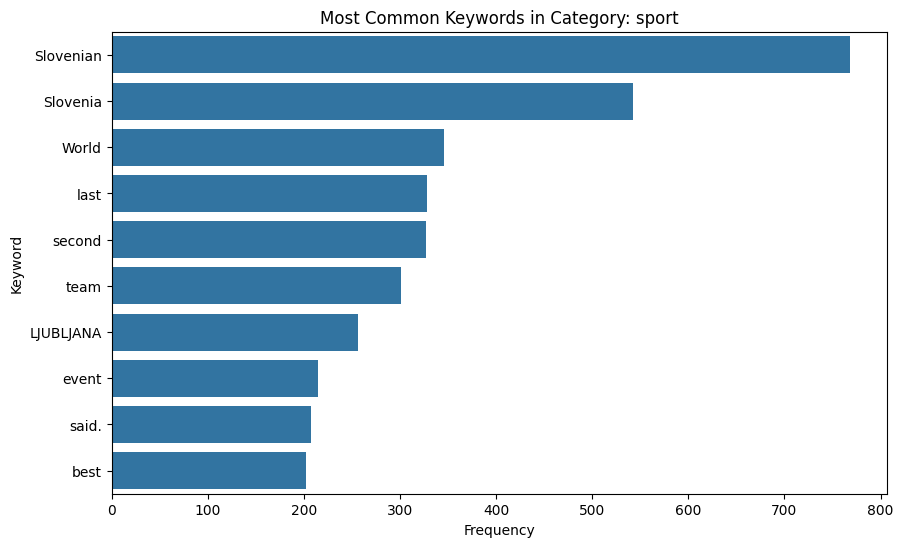

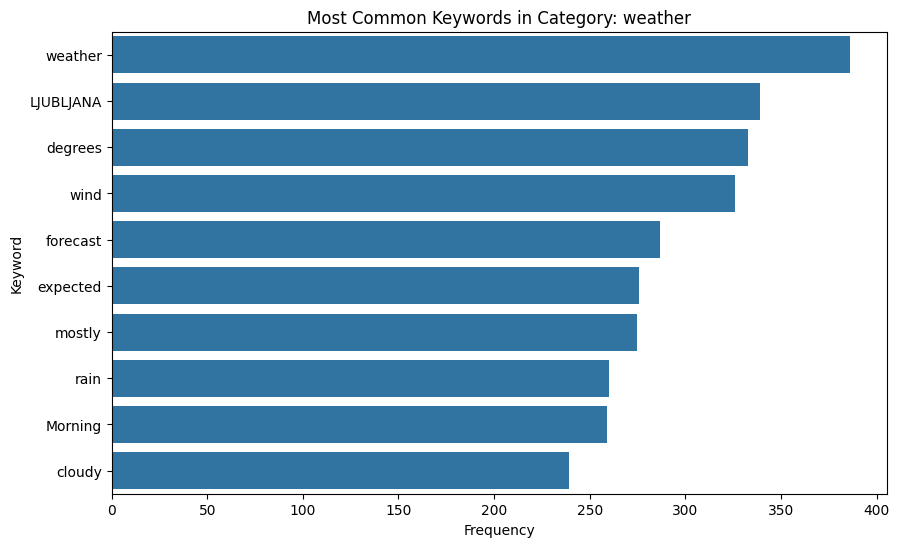

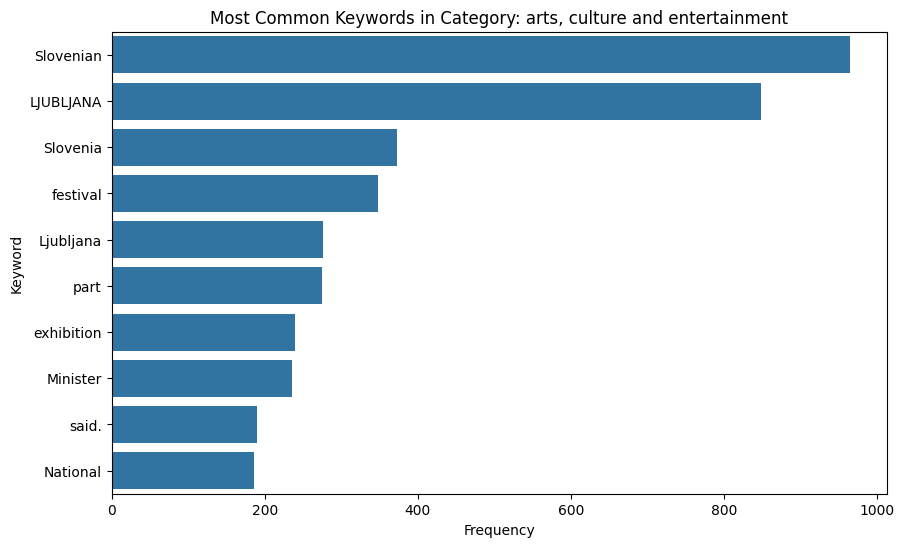

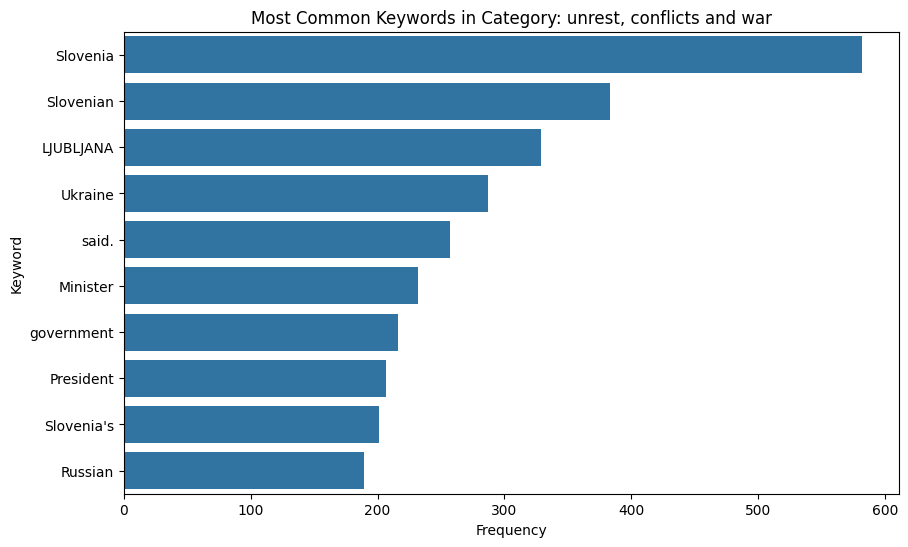

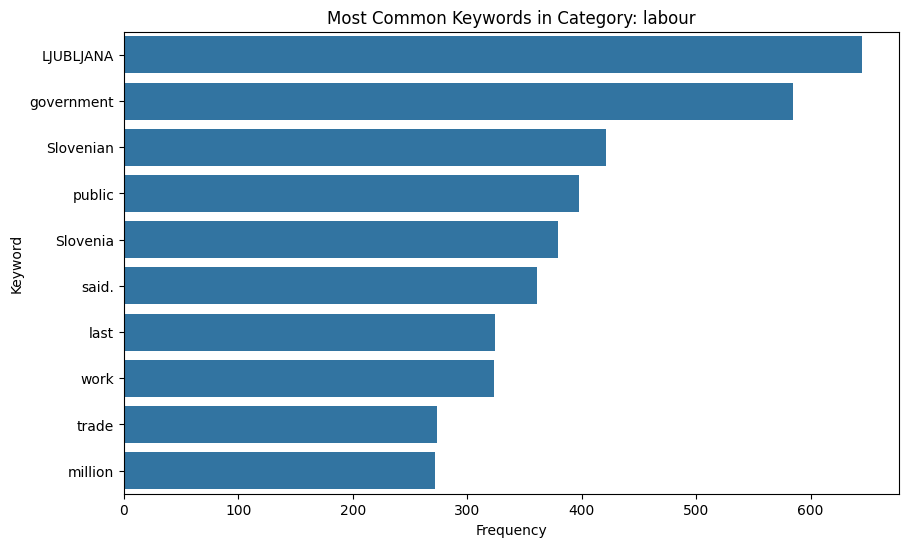

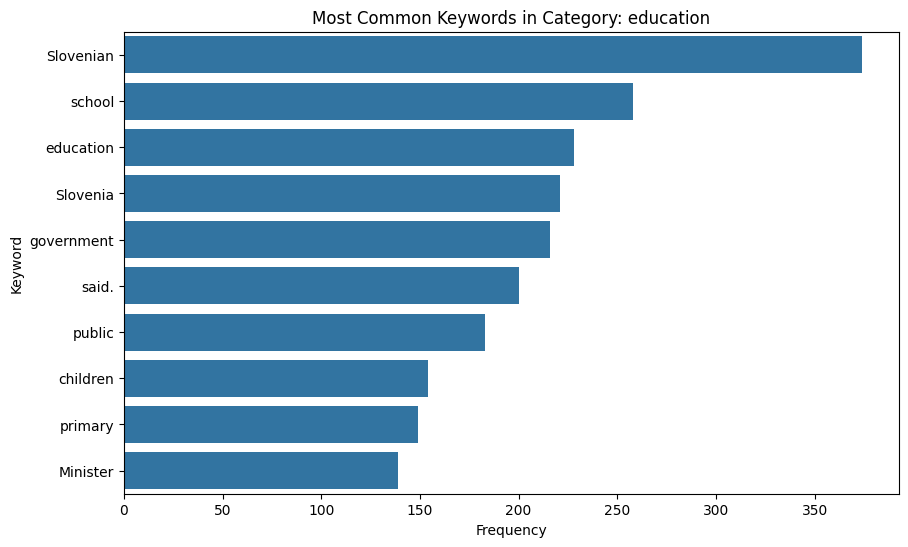

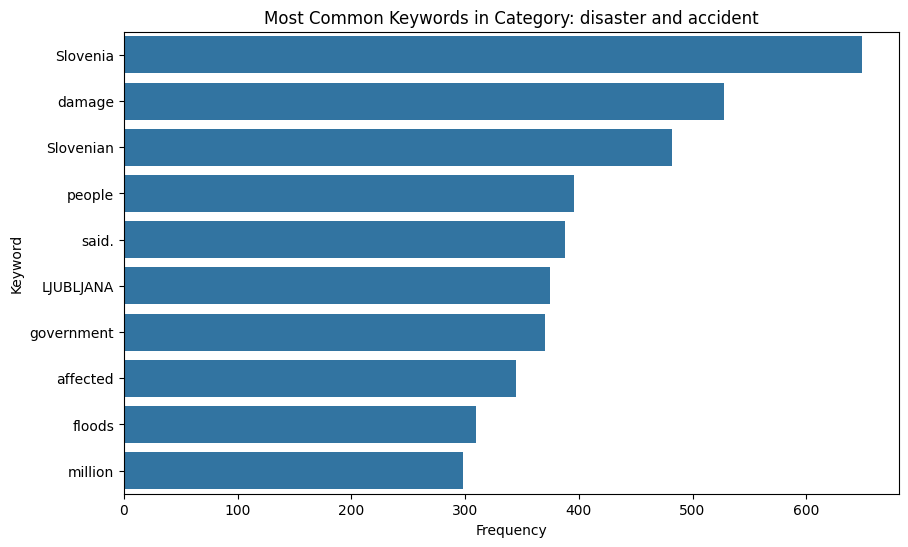

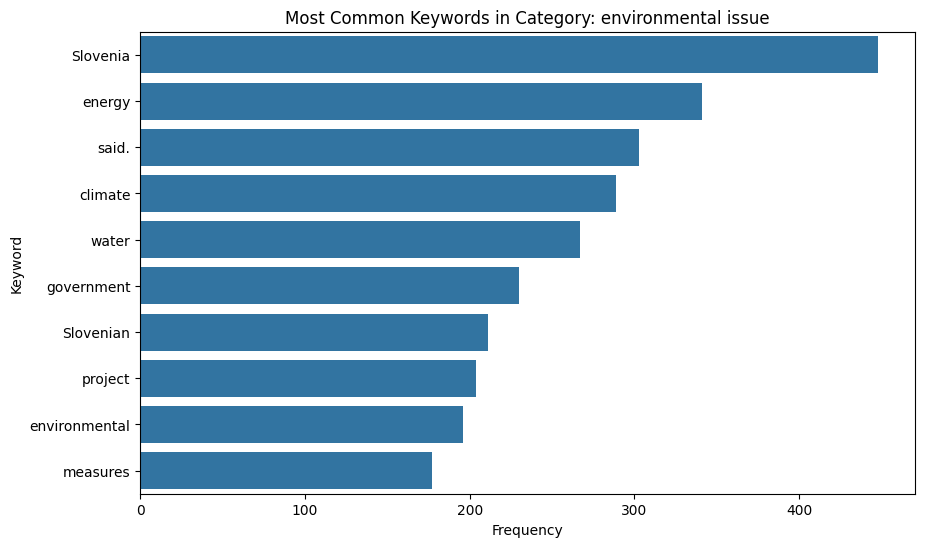

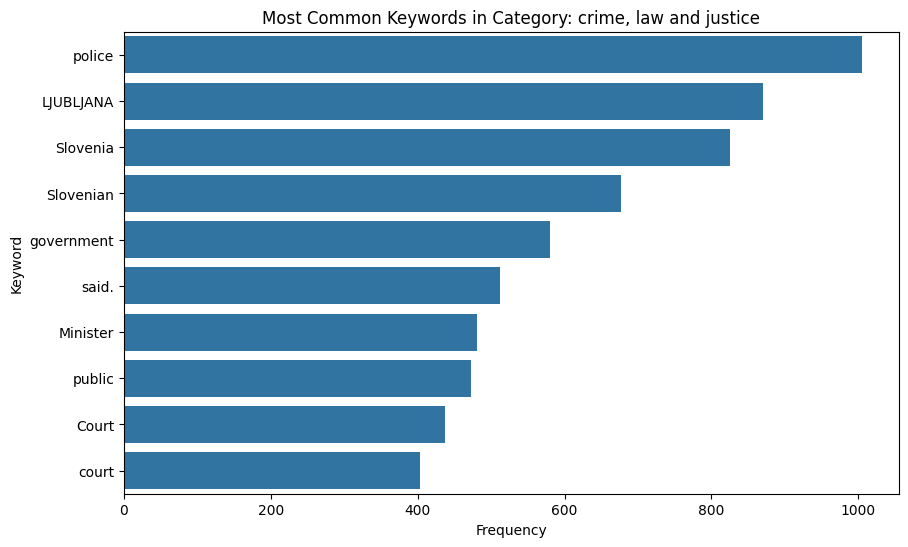

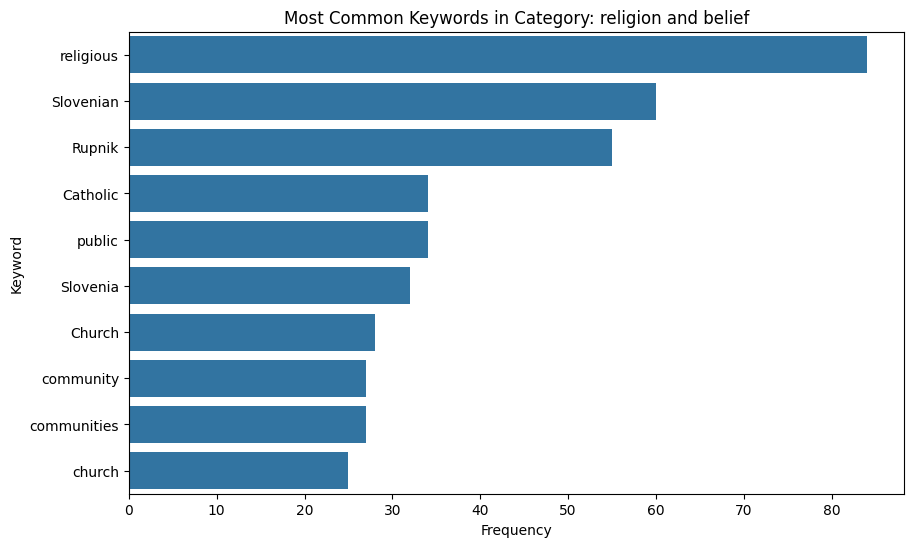

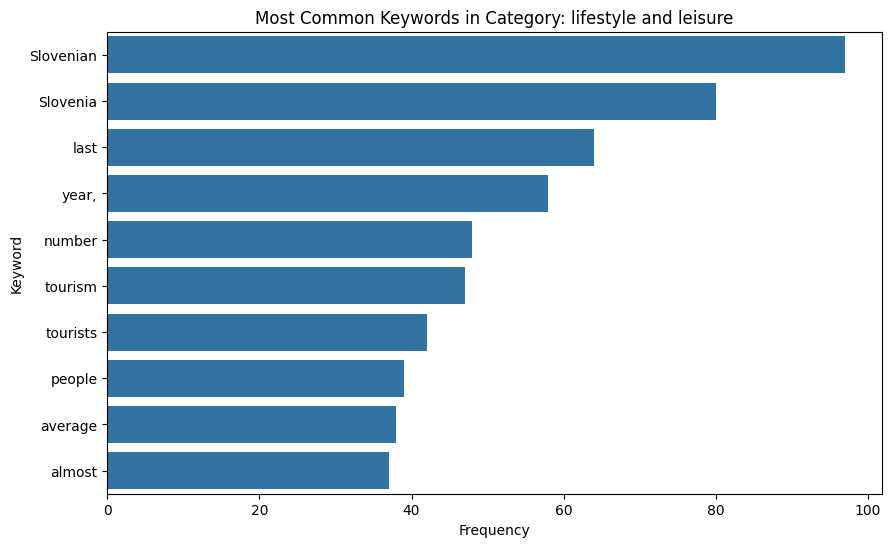

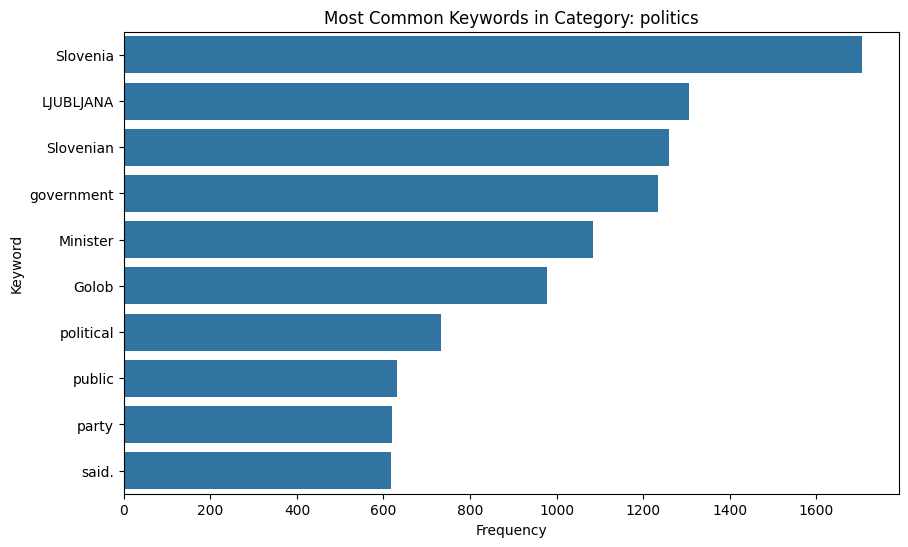

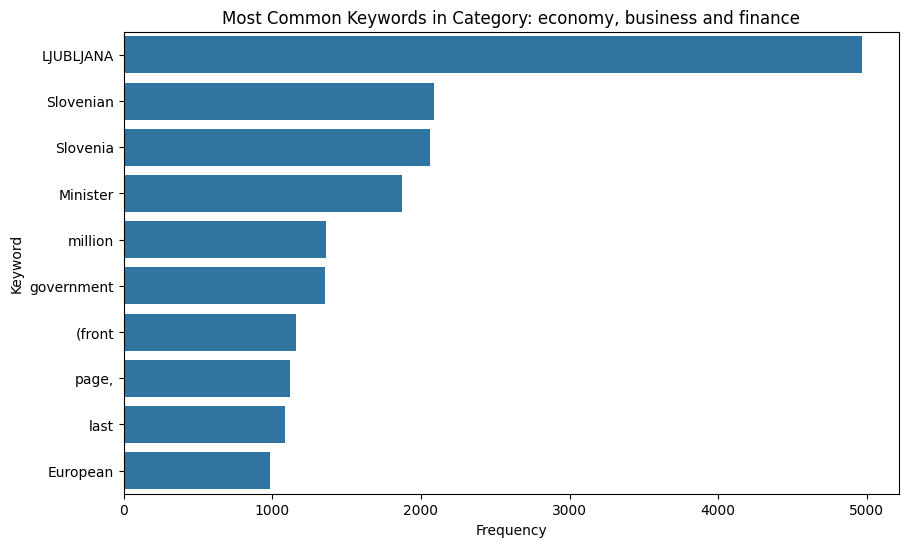

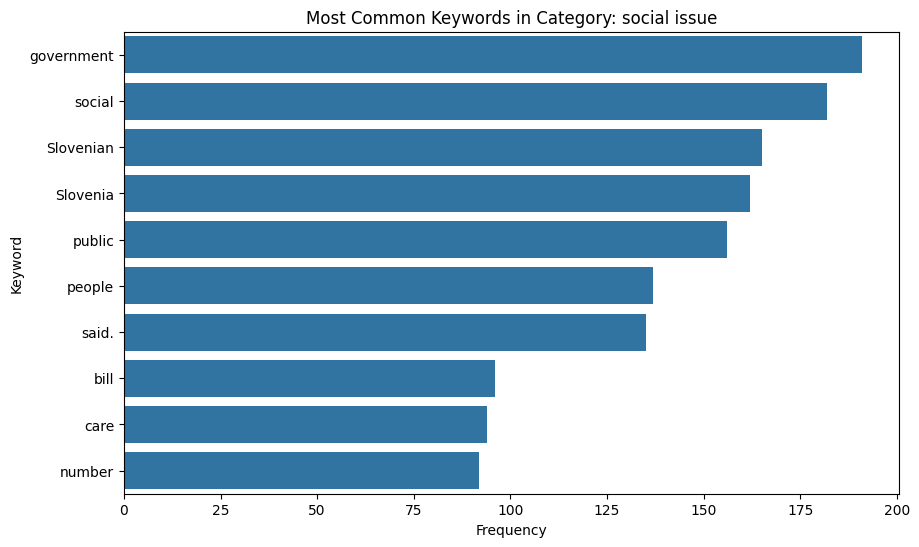

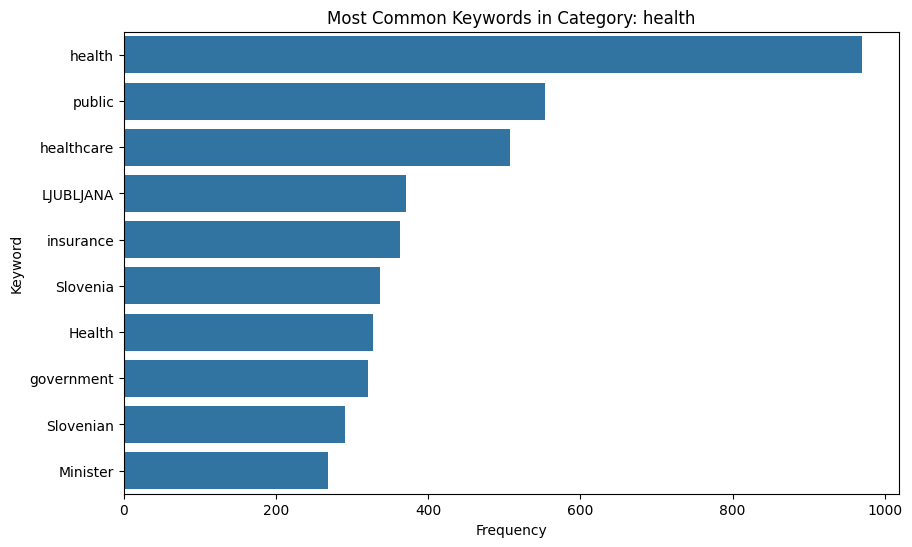

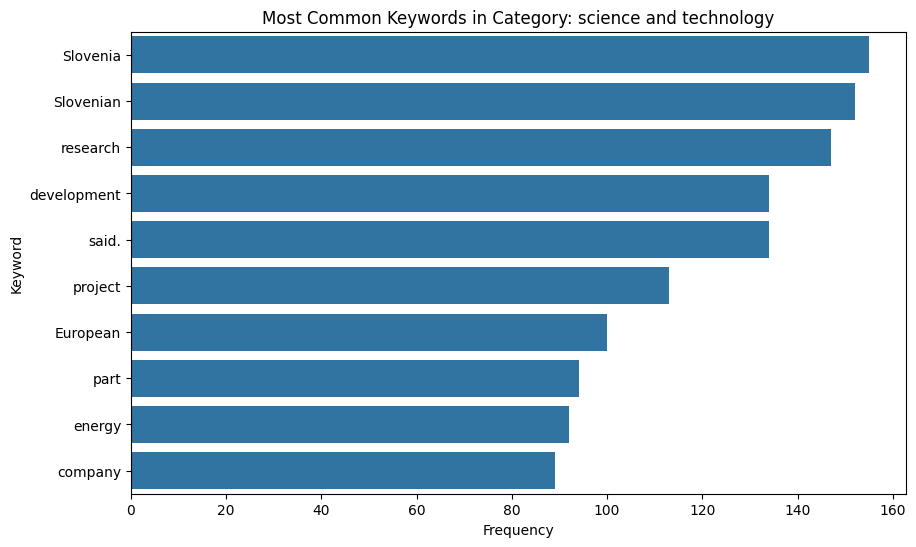

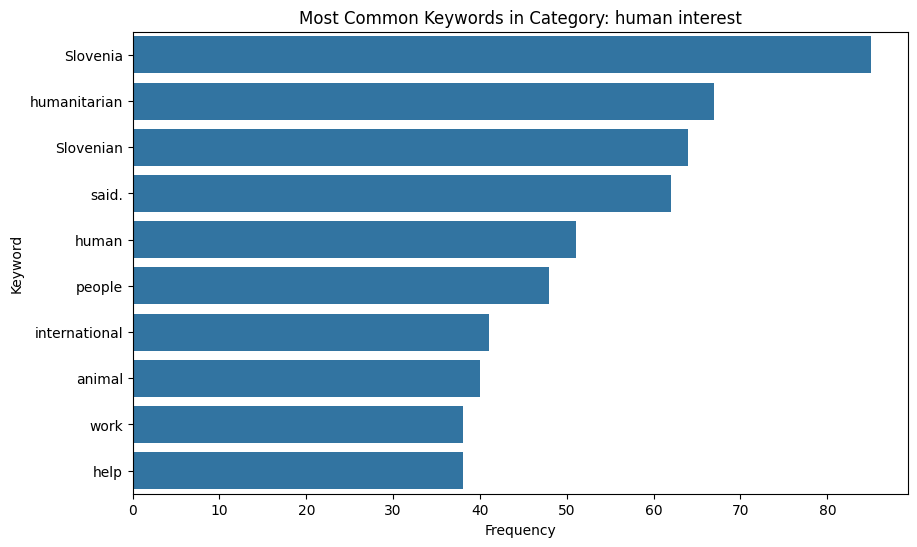

In [260]:

for category in categories:
    keywords_with_counts = category_keywords[category][:num_keywords_to_plot]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[count for word, count in keywords_with_counts], y=[word for word, count in keywords_with_counts])
    plt.xlabel('Frequency')
    plt.ylabel('Keyword')
    plt.title(f'Most Common Keywords in Category: {category}')
    plt.show()
